# Centering

This notebook contains an algorithm that can find the center of an overdensity in a catlog. This was originally used to find the centers of galaxy clusters, but there are probably other uses.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy import convolution

We would normally read in the data from a catlog, but for this it will be easy to make a fake cluster. It has background sources randomly scattered throughout, then a "cluster" that is just a Gaussian. Our "image" will be 5 arcseconds square. The cluster will be centered at ra=0.05 and dec=0.02, and the Gaussian that represents the cluster will have a scale of 0.5 arcminutes. The background will have 100 objects, and the cluster will have 200.

When using this code in your own usage, just replace the ras and decs with your lists of values.

In [2]:
ras =  np.concatenate([np.random.uniform(0, 5.0 / 60.0, 1000),
                       np.random.normal(0.05, 0.5 / 60.0, 200)])  
decs = np.concatenate([np.random.uniform(0, 5.0 / 60.0, 1000),
                       np.random.normal(0.02, 0.5 / 60.0, 200)]) 

We can then plot the objects in our catalog, to make sure it's reasonable.

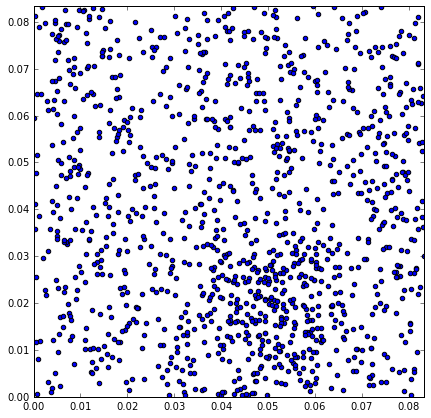

In [3]:
fig, ax = plt.subplots(figsize=[7, 7])
plt.scatter(ras, decs)
plt.xlim(0, 5.0 / 60.0)
plt.ylim(0, 5.0 / 60.0)
ax.set_aspect("equal", adjustable="box")

# Finding the center

The real work starts here. We will create bins with equal spacing in ra and dec, then make a 2D histogram using those bins. We will then smooth it to see where the peaks are. We will use very small bins, which seems silly in the initial density histogram, but works better when smoothed.

In [4]:
# we want bin sizes of 1 arcsecond on a side.
dec_bin_size = 1.0 / 3600.0  # get in degrees
# since x in is RA units, we have to take that cosine term in to account
middle_dec = (max(decs) + min(decs)) / 2.0
ra_bin_size = dec_bin_size / np.cos(middle_dec * np.pi / 180.0)

We need a function to turn a bin_size into actual bin edges that span the data, which is what the 2D histogram function takes.

In [5]:
def bin_edges(data, bin_size):
    edges = [min(data)]
    while edges[-1] < max(data):
        edges.append(edges[-1] + bin_size)
    return edges

In [6]:
ra_bins = bin_edges(ras, ra_bin_size)
dec_bins = bin_edges(decs, dec_bin_size)

We can then use the 2D histogram function to get an initial density map.

In [7]:
hist, _, _ = np.histogram2d(ras, decs, bins=[ra_bins, dec_bins])

We use astropy to smooth, using their Gaussian kernel. The kernel works in array space, not real space, so we have to figure out how many "pixels" wide our Gaussian needs to be to correspond to the real space scale we want to smooth on.

In [8]:
# we will smooth on 0.5 Arcminute scales. See how many "resolution elements" that is.
smoothing_factor = 0.5 / (dec_bin_size * 60)

kernel = convolution.Gaussian2DKernel(stddev=smoothing_factor)

Then we can use it to smooth our density map.

In [9]:
smoothed_hist = convolution.convolve(hist, kernel)

We then need to find the maximum location in that smoothed array. This is a little tricky, since apparently numpy does not have a function to find the 2d indicies of the max item in an array.

In [10]:
max_idx = np.argmax(smoothed_hist)  # this is on the flattened array
ra_idx = max_idx // smoothed_hist.shape[1]  
dec_idx = max_idx % smoothed_hist.shape[1]

We then turn this into ra/dec coordinates, using our bin size. The last term is to put the ra/dec at the center of the bin.

In [11]:
ra_cen = min(ras) + ra_bin_size * ra_idx + (ra_bin_size / 2.0)
dec_cen = min(decs) + dec_bin_size * dec_idx + (dec_bin_size / 2.0)

We originally set the center to be at ra=0.05, dec=0.02. Let's see how close we got (in arcseconds).

In [12]:
(ra_cen - 0.05) * 3600, (dec_cen - 0.02) * 3600

(2.6146562196812329, 0.060130632068181034)

We'll then plot it up to verify things visually. We'll plot the points and our smoothed density estimae. `imshow` is weird, and we have to rotate our array to have it line up with the actual sources.

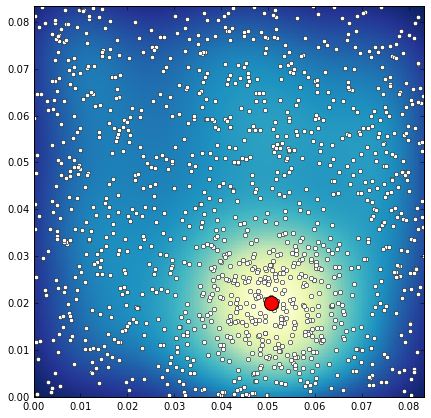

In [13]:
fig, ax = plt.subplots(figsize=[7, 7])

ax.imshow(np.rot90(smoothed_hist), interpolation="none", cmap="YlGnBu_r",
          extent=[min(ra_bins), max(ra_bins), min(dec_bins), max(dec_bins)])
ax.scatter(ras, decs, c="w", lw=0.5)
ax.scatter([ra_cen], [dec_cen], s=200, c="red")
ax.set_aspect("equal", adjustable="box")
plt.xlim(0, 5.0 / 60.0)
plt.ylim(0, 5.0 / 60.0);

This looked like it worked.